In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import cvutils as cvu

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

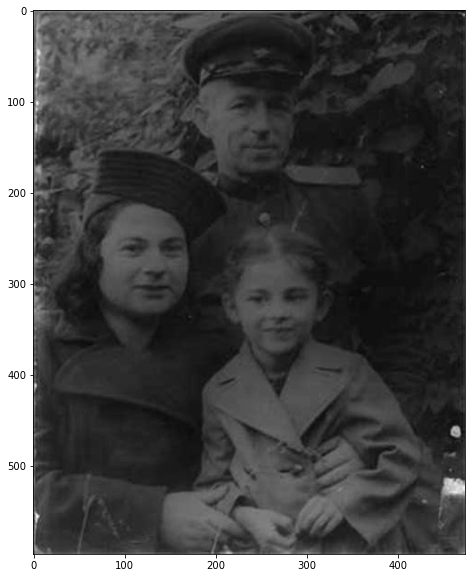

In [3]:
im = cv2.imread('./images/contrast/family1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap='gray')

<AxesSubplot:ylabel='Count'>

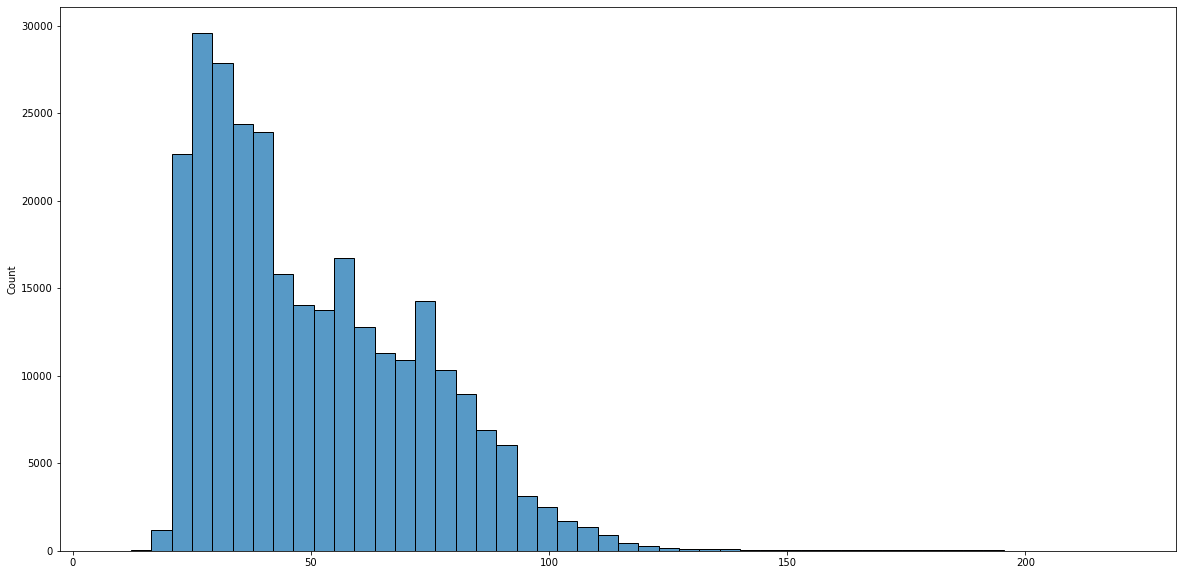

In [4]:
sns.histplot(im.reshape(-1), bins=50)

## Binning

In [5]:
def binning(values, bins, ids=None):
    values = np.array(values)
    if ids is None:
        ids = np.arange(values.shape[0])
    inf_f = np.min(ids)
    sup_f = np.max(ids)
    
    new_ids = np.zeros(bins)
    new_values = np.zeros(bins)

    rs = np.linspace(0, 256, bins+1)
    rs[bins] += 1
    for k in range(bins):
        start = rs[k]
        end = rs[k + 1]

        new_values[k] = np.sum(values[(ids >= start) & (ids < end)])
    rs[bins] -= 1
    
    return rs[:-1], new_values

# Histogram Calculation

In [6]:
class Histogram:
    def __init__(self, in_im):
        self.im = in_im
        self.size = 256
    
    def get_hist(self, bins=256):
        counts = np.zeros(self.size)
        intensities, pix_counts = np.unique(self.im, return_counts=True)
        
        for intensity, pix_count in zip(intensities, pix_counts):
            counts[intensity] = pix_count
            
        hist = counts / np.prod(self.im.shape)
        return binning(hist, bins, np.arange(self.size))
    
    def get_cum_hist(self, bins=256):
        ids, values = self.get_hist(bins)
        return ids, np.cumsum(values)
    
    def get_transform(self):
        return self.get_cum_hist()[1]
    
    def get_equalization_map(self):
        return np.rint(self.get_transform() * 255).astype(np.uint8)
    
    def get_inverse_transform(self):
        T = self.get_equalization_map()
        counts = np.zeros(self.size)
        
        for t in T:
            counts[t] += 1
            
        return np.cumsum(counts) / np.prod(T.shape)
    
    def get_inverse_equalization_map(self):
        return np.rint(self.get_inverse_transform() * 255).astype(np.uint8)
    
#     def get_equalized_cum_hist(self):
#         t = self.get_equalization_map()
#         return t, self.get_cum_hist()[1][t]
    
    def equalize(self, target_im=None):
        if target_im is None:
            target_im = self.im
#         target_im = cvu.norm(im).astype(np.uint8)
        return self.get_equalization_map()[target_im]

In [7]:
im_hist = Histogram(im)

<AxesSubplot:>

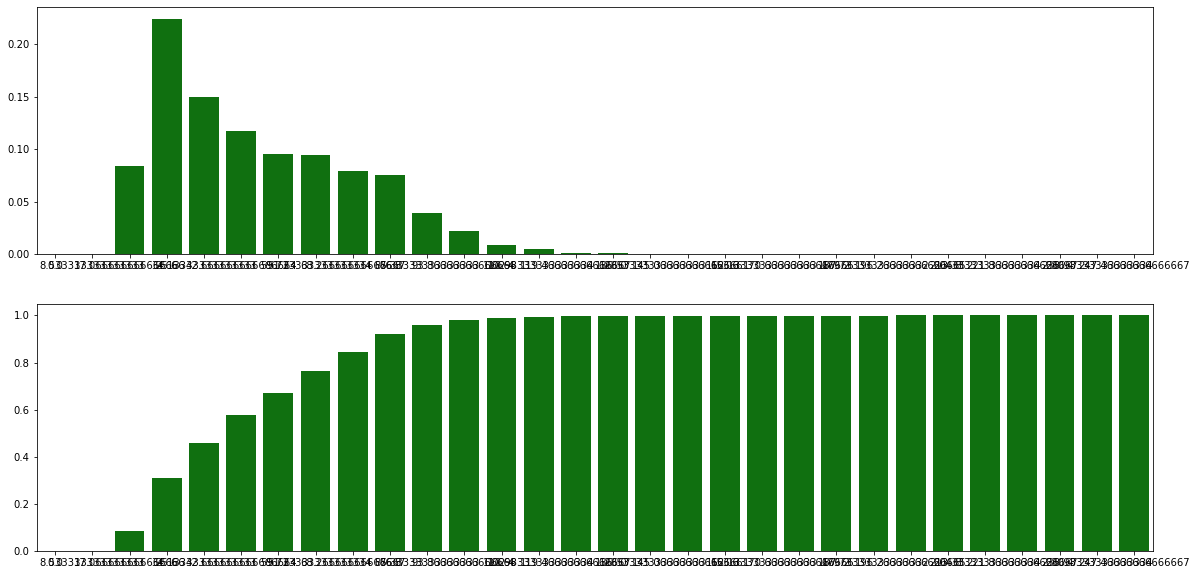

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1)

bins_num=30
im_hist_ids, im_hist_vals = im_hist.get_hist(bins=bins_num)
im_cum_hist_ids, im_cum_hist_vals = im_hist.get_cum_hist(bins=bins_num)

sns.barplot(x=im_hist_ids, y=im_hist_vals, ax=axes[0], color='g')
sns.barplot(x=im_cum_hist_ids, y=im_cum_hist_vals, ax=axes[1], color='g')

## Histogram Equalization

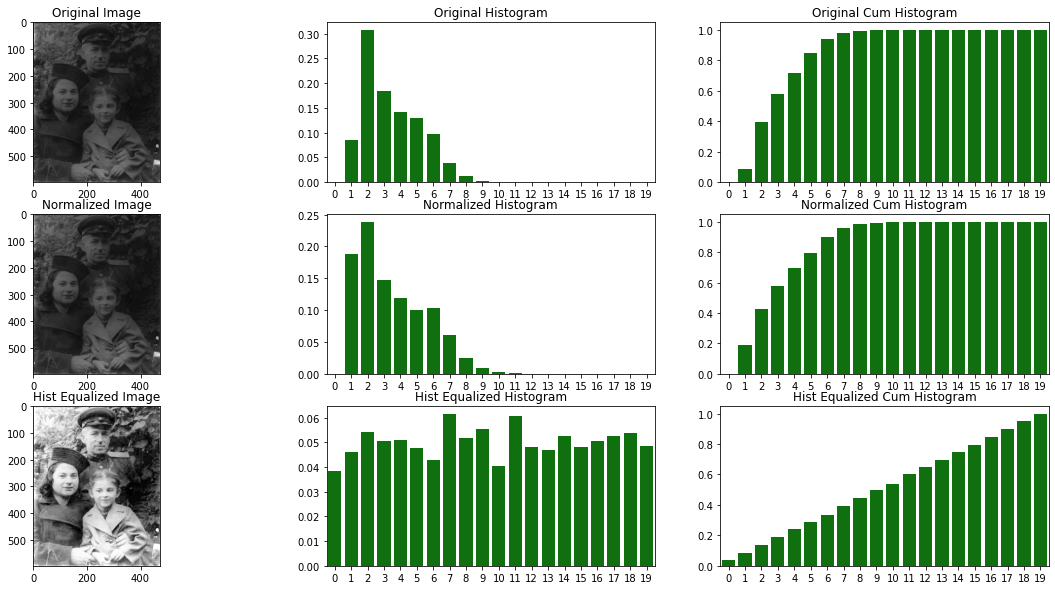

In [9]:
im_norm = cvu.norm(im)
im_norm = np.rint(im_norm).astype(np.uint8)
im_norm_hist = Histogram(im_norm)
# plt.imshow(cvu.concatenate([im, im_equalized], (1, 2)), cmap='gray')

im_equalized = im_hist.equalize(im)
im_equ_hist = Histogram(im_equalized)

fig, axes = plt.subplots(nrows=3, ncols=3)
bins_num = 20;

axes[0, 0].set_title("Original Image")
axes[0, 0].imshow(im, cmap='gray')
axes[0, 1].set_title("Original Histogram")
sns.barplot(x=np.arange(bins_num), y=im_hist.get_hist(bins_num)[1], ax=axes[0, 1], color='g')
axes[0, 2].set_title("Original Cum Histogram")
sns.barplot(x=np.arange(bins_num), y=im_hist.get_cum_hist(bins_num)[1], ax=axes[0, 2], color='g')

axes[1, 0].set_title("Normalized Image")
axes[1, 0].imshow(im_norm, cmap='gray')
axes[1, 1].set_title("Normalized Histogram")
sns.barplot(x=np.arange(bins_num), y=im_norm_hist.get_hist(bins_num)[1], ax=axes[1, 1], color='g')
axes[1, 2].set_title("Normalized Cum Histogram")
sns.barplot(x=np.arange(bins_num), y=im_norm_hist.get_cum_hist(bins_num)[1], ax=axes[1, 2], color='g')

axes[2, 0].set_title("Hist Equalized Image")
axes[2, 0].imshow(im_equalized, cmap='gray')
axes[2, 1].set_title("Hist Equalized Histogram")
sns.barplot(x=np.arange(bins_num), y=im_equ_hist.get_hist(bins_num)[1], ax=axes[2, 1], color='g')
axes[2, 2].set_title("Hist Equalized Cum Histogram")
sns.barplot(x=np.arange(bins_num), y=im_equ_hist.get_cum_hist(bins_num)[1], ax=axes[2, 2], color='g')


plt.savefig('./figs/hist/hist_equalization.png')

### Equalized Intenzity is the same as the Histogram value for the intensity

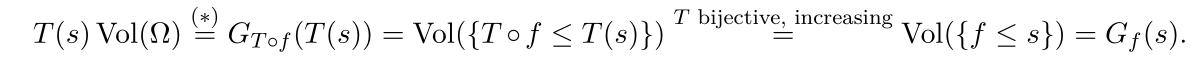

In [10]:
im_hist.get_equalization_map()[38]/255  # T(s) * Vol(Sigma)

0.39215686274509803

In [11]:
# G_{Tf}(T(s)) --- The intensity T(s) in the Equalized Cummulative Histogram. E.g. T(s) = 100 for s = 35
im_equ_hist.get_cum_hist()[1][im_hist.get_equalization_map()[38]] 

0.39200220511841916

In [12]:
# G_f(s) --- The intesity s in the Cummulative Histogram
im_hist.get_cum_hist()[1][38]

0.39200220511841916

### Transform function vs Cummulative Histogram

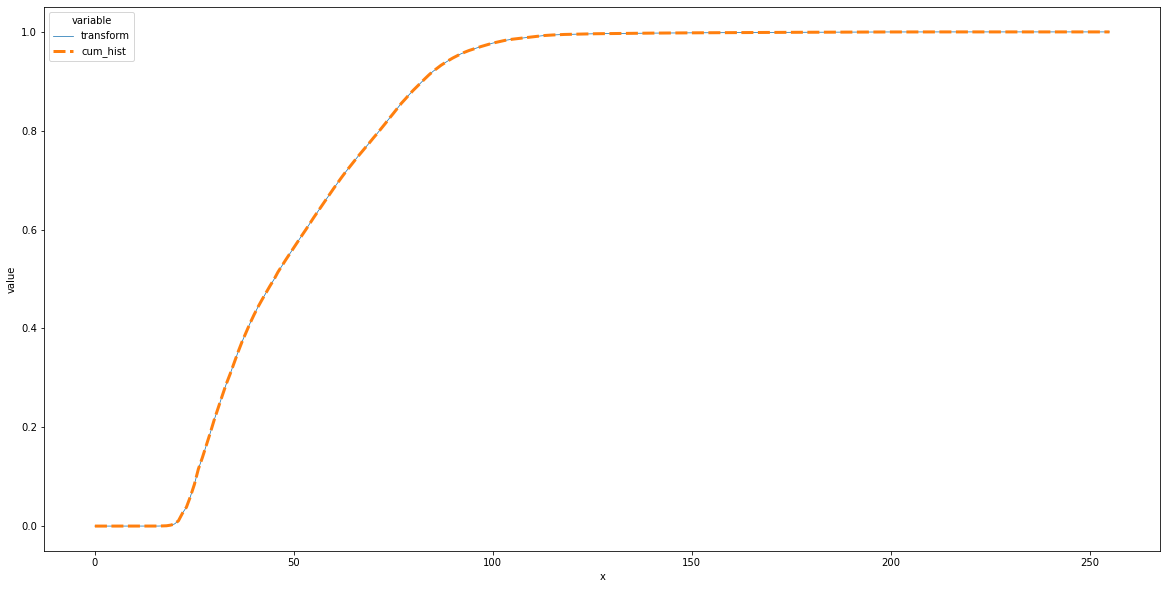

In [13]:
df = pd.DataFrame({})

df['x'] = np.arange(256)
df['transform'] = im_hist.get_transform()
df['cum_hist'] = im_hist.get_cum_hist()[1]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['transform', 'cum_hist'])

fig = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable', size='variable', size_order=['cum_hist', 'transform'])
plt.rcParams['figure.figsize'] = (20, 10)
plt.savefig('./figs/hist/transform_vs_cum_hist.png')

### Equalized Histogram vs Histogram of $T^{-1}$

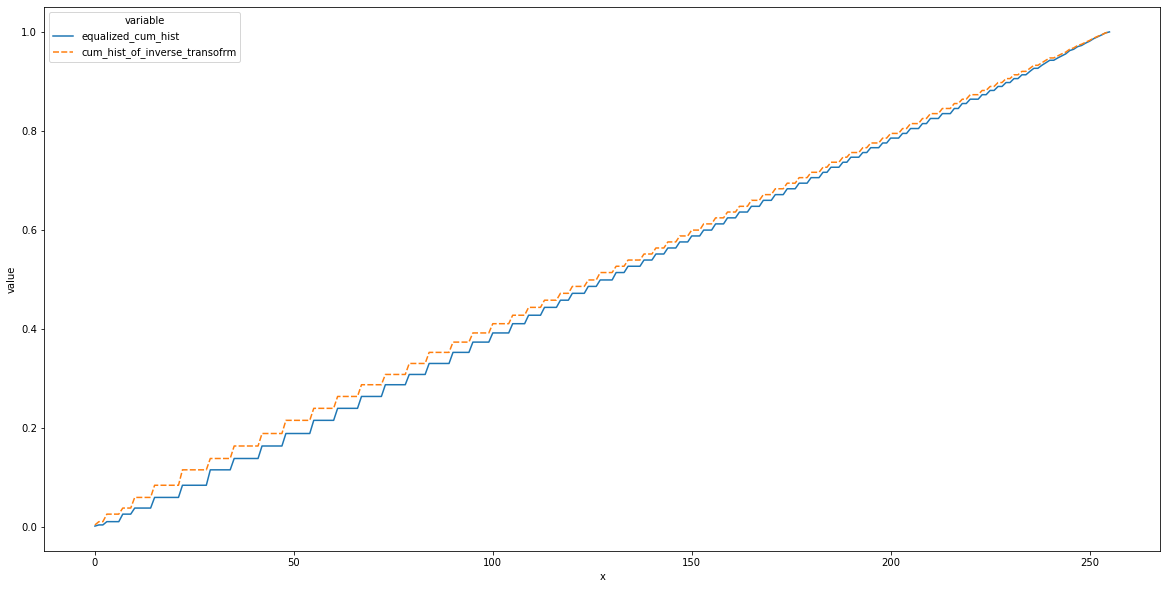

In [14]:
df = pd.DataFrame({})

df['x'] = np.arange(256)
df['equalized_cum_hist'] = im_equ_hist.get_cum_hist()[1]
df['cum_hist_of_inverse_transofrm'] = im_hist.get_cum_hist()[1][im_hist.get_inverse_equalization_map()]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['equalized_cum_hist', 'cum_hist_of_inverse_transofrm'])

fig = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable')
plt.savefig('./figs/hist/equ_cum_hist-vs-cum_hist_of_inverse.png')

Comparison of the functions $T=\frac{G_f(s)}{Vol(\Omega)}$ and $T^{-1}=G_f^{-1}(s \cdot Vol(\Omega))$

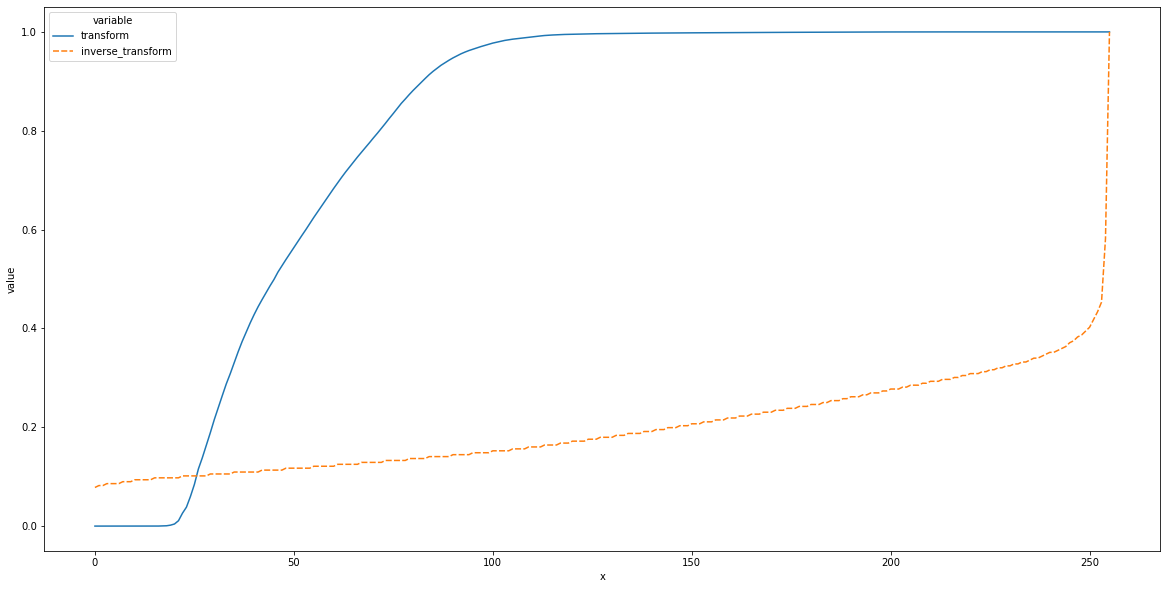

In [15]:
df = pd.DataFrame({})

df['x'] = np.arange(256)
df['transform'] = im_hist.get_transform()
df['inverse_transform'] = im_hist.get_inverse_transform()
df_melted = pd.melt(df, id_vars=['x'], value_vars=['transform', 'inverse_transform'])

fig = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable')
plt.savefig('./figs/hist/transform-vs-inverse_transform.png')

## Histogram Matching
First we will prepare new image where we will edit the intensities by applying a gamma filter. Then with histogram matching we hope that we will be able to recover the original image.

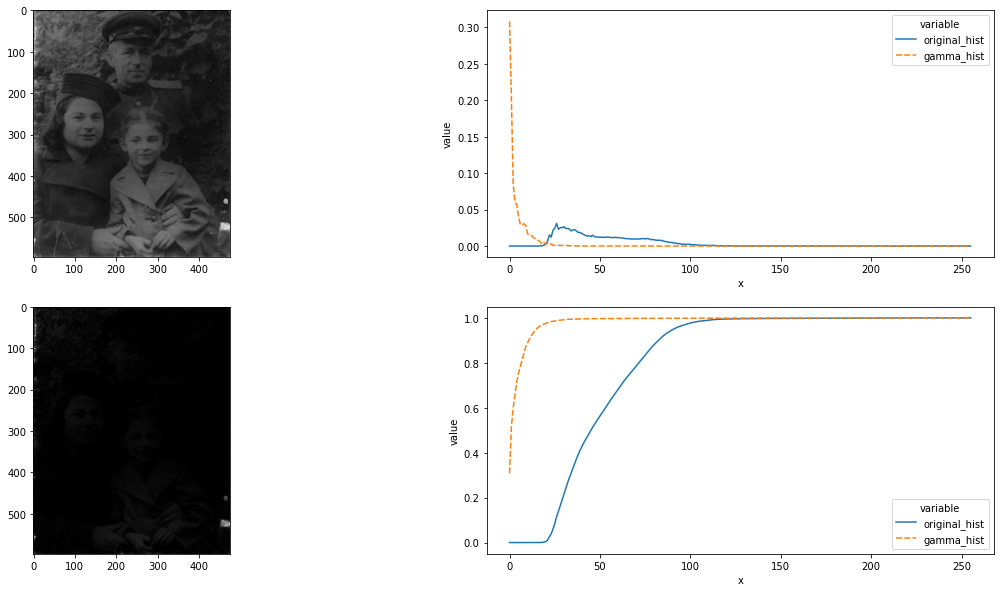

In [45]:
im_gamma = cvu.gamma_correction(im, gamma=3)
# im_gamma = im
im_gamma = np.rint(im_gamma).astype(np.uint8)
fig, axes = plt.subplots(nrows=2, ncols=2)

im_gamma_hist = Histogram(im_gamma)

axes[0,0].imshow(im, cmap='gray')
axes[1,0].imshow(im_gamma, cmap='gray')

df['x'] = np.arange(256)
df['original_hist'] = im_hist.get_hist()[1]
df['gamma_hist'] = im_gamma_hist.get_hist()[1]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['original_hist', 'gamma_hist'])

g = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable', ax=axes[0, 1])

df['x'] = np.arange(256)
df['original_hist'] = im_hist.get_cum_hist()[1]
df['gamma_hist'] = im_gamma_hist.get_cum_hist()[1]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['original_hist', 'gamma_hist'])

g = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable', ax=axes[1, 1])

plt.savefig('./figs/hist-vs-gamma_hist.png')


### Now we aim to perform the histogram matching and obtain the exactly same image (or close to the original).

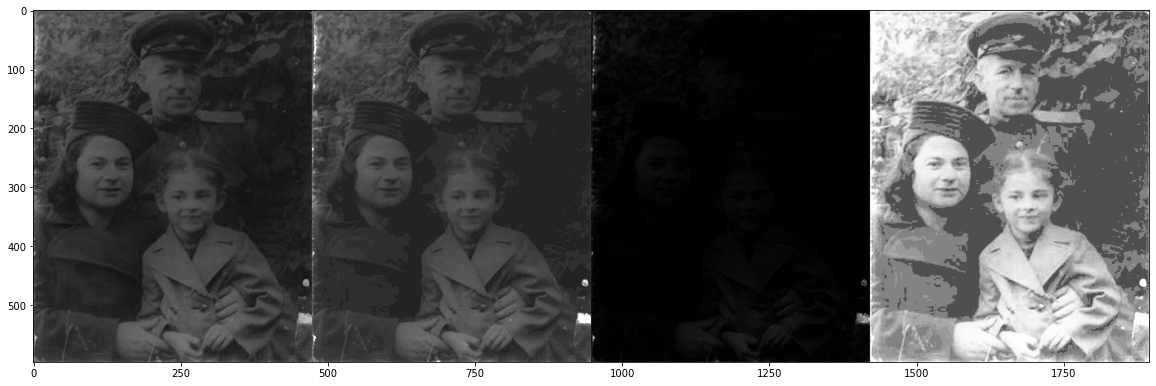

In [48]:
im_gamma_equalized = im_gamma_hist.equalize(im_gamma)
im_gamma_matched = im_hist.get_inverse_equalization_map()[im_gamma_equalized]

plt.imshow(cvu.concatenate([im, im_gamma_matched, im_gamma, im_gamma_equalized], layout=(1,4)), cmap='gray')

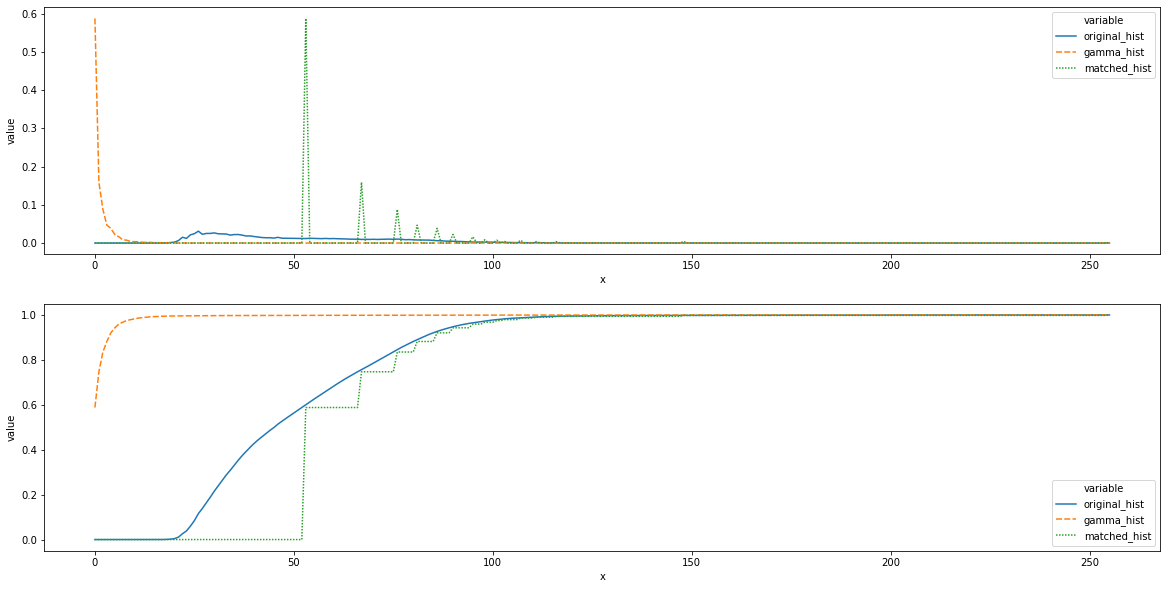

In [42]:
im_gamma_matched_hist = Histogram(im_gamma_matched)

fig, axes = plt.subplots(nrows=2, ncols=1)

df['x'] = np.arange(256)
df['original_hist'] = im_hist.get_hist()[1]
df['gamma_hist'] = im_gamma_hist.get_hist()[1]
df['matched_hist'] = im_gamma_matched_hist.get_hist()[1]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['original_hist', 'gamma_hist', 'matched_hist'])

g = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable', ax=axes[0])

df['x'] = np.arange(256)
df['original_hist'] = im_hist.get_cum_hist()[1]
df['gamma_hist'] = im_gamma_hist.get_cum_hist()[1]
df['matched_hist'] = im_gamma_matched_hist.get_cum_hist()[1]
df_melted = pd.melt(df, id_vars=['x'], value_vars=['original_hist', 'gamma_hist', 'matched_hist'])

g = sns.lineplot(data=df_melted, x='x', y='value', hue='variable', style='variable', ax=axes[1])

plt.savefig('./figs/hist-vs-gamma_hist-vs-matched_hist.png')